In [ ]:
# docker run -p 6333:6333 qdrant/qdrant
# pip install langgraph langchain langchain-community qdrant-client groq sqlparse asttokens javalang

In [24]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda
from langchain_groq import ChatGroq
from langchain_community.vectorstores import Qdrant
from langchain.embeddings import HuggingFaceEmbeddings
from qdrant_client import QdrantClient
from langchain.schema import Document
from typing import TypedDict, List, Optional
from qdrant_client.http.models import Distance, VectorParams


import sqlparse, javalang, asttokens, ast, os, uuid, json
from dotenv import load_dotenv
load_dotenv()


True

In [60]:
class CodeState(TypedDict):
    file_path: Optional[str]
    code: Optional[str]
    metadata_file: Optional[str]
    language: Optional[str]
    chunks: Optional[List[str]]
    summaries: Optional[List[str]]
    high_level_doc: Optional[str]
    detailed_doc: Optional[str]
    table_names: Optional[List[str]]

In [ ]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.3)

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
qdrant_client = QdrantClient(host="localhost", port=6333)

# Create collection
qdrant_client.recreate_collection(
    collection_name="code_chunks",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE)
)


vector_store = Qdrant(
    client=qdrant_client,
    collection_name="code_chunks",
    embeddings=embedding_model
)

C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_13276\1450245719.py:10: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


In [56]:
def read_code_file(state):
    # If raw code is already provided, skip file reading
    if "code" in state and state["code"]:
        return state

    file_path = state.get("file_path")
    if not file_path or not os.path.exists(file_path):
        return {**state, "error": f"File not found: {file_path}"}

    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            code = f.read()
        return {**state, "code": code}
    except Exception as e:
        return {**state, "error": f"Failed to read file: {str(e)}"}

In [7]:
# A simple language detection function
def detect_language(state):
    code = state["code"]
    if "BEGIN" in code and "END" in code: lang = "sql"
    elif "public class" in code: lang = "java"
    elif "def " in code: lang = "python"
    elif "namespace" in code or "using System": lang = "csharp"
    else: lang = "unknown"
    return {**state, "language": lang}

In [8]:
# Chunking + table name extraction function
def chunk_code(state):
    code, lang = state["code"], state["language"]
    chunks = []

    if lang == "sql":
        parsed = sqlparse.parse(code)
        for stmt in parsed:
            block = str(stmt).strip()
            if block: chunks.append(block)

    elif lang == "java":
        tree = javalang.parse.parse(code)
        for _, node in tree.filter(javalang.tree.MethodDeclaration):
            chunks.append(node.name + " method:\n" + str(node.body))

    elif lang == "python":
        atok = asttokens.ASTTokens(code, parse=True)
        for node in atok.tree.body:
            if isinstance(node, (ast.FunctionDef, ast.ClassDef)):
                chunks.append(atok.get_text(node))

    elif lang == "csharp":
        chunks = code.split("public")

    return {**state, "chunks": chunks}

In [ ]:
#Summarization function with error handling
def summarize_chunks(state):
    summaries = []
    table_metadata = fetch_table_metadata(state.get("table_names", []))

    for i, chunk in enumerate(state["chunks"]):
        if not chunk.strip() or len(chunk.strip()) < 20:
            summaries.append("⚠️ Skipped: Fragment too small or empty.")
            continue

        prompt = f"""
You are a code summarizer. Analyze the following {state['language']} code block.
Provide:
1. High-level purpose
2. Detailed logic explanation
3. Mention variables, control flow, and table usage

Chunk #{i}:
{chunk}

Relevant Table Metadata:
{table_metadata}
"""

        # try:
        response = llm.invoke(prompt)
        summaries.append(response.content.strip())
        # except Exception:
            # summaries.append("⚠️ Failed to summarize due to model error or malformed input.")

    return {**state, "summaries": summaries}

In [10]:
#Store chunks in Qdrant
def store_chunks_in_qdrant(state):
    documents = []
    for i, (chunk, summary) in enumerate(zip(state["chunks"], state["summaries"])):
        documents.append(Document(
            page_content=summary,
            metadata={
                "chunk_id": i,
                "language": state["language"],
                "code": chunk
            }
        ))
    vector_store.add_documents(documents)
    return state

In [47]:
def generate_documents(state):
    high_level = f"📘 High-Level Summary for {state['language']} Code\n\n"
    detailed = f"📗 Detailed Logic-Level Summary\n\n"

    for i, summary in enumerate(state["summaries"]):
        detailed += f"🔸 Chunk {i} Full Explanation:\n{summary}\n\n"

        # Extract purpose using LLM
        purpose_prompt = f"""
Extract the high-level purpose of this code block summary:

{summary}

Respond with a single sentence that describes what this block is doing overall.
"""
        # try:
        purpose_response = llm.invoke(purpose_prompt)
        high_level += f"🔹 Chunk {i} Purpose:\n{purpose_response.content.strip()}\n\n"
        # except Exception:
            # high_level += f"🔹 Chunk {i} Purpose:\n⚠️ Failed to extract purpose.\n\n"

    return {
        **state,
        "high_level_doc": high_level,
        "detailed_doc": detailed
    }

In [66]:
def convert_metadata_dict_to_list(metadata_dict):
    return [
        {
            "table_name": name,
            "description": info["description"],
            "columns": info["columns"]
        }
        for name, info in metadata_dict.items()
    ]

In [73]:
def ingest_table_metadata(state):
    metadata_path = state.get("metadata_file")
    if not metadata_path or not os.path.exists(metadata_path):
        return state

    with open(metadata_path, "r", encoding="utf-8") as f:
        raw_metadata = json.load(f)

    # Normalize to list format
    if isinstance(raw_metadata, dict) and "table_name" in raw_metadata:
        metadata_list = [raw_metadata]
    elif isinstance(raw_metadata, dict):
        # Convert dict-of-tables format to list
        metadata_list = [
            {
                "table_name": name,
                "description": info["description"],
                "columns": info["columns"]
            }
            for name, info in raw_metadata.items()
        ]
    elif isinstance(raw_metadata, list):
        metadata_list = raw_metadata
    else:
        raise ValueError("Invalid metadata format. Must be a dict or list of dicts.")

    docs = []
    table_names = []

    for metadata in metadata_list:
        doc = Document(
            page_content=json.dumps(metadata, indent=2),
            metadata={
                "type": "table_metadata",
                "table_name": metadata["table_name"],
                "description": metadata["description"],
                "columns": metadata["columns"]
            }
        )
        docs.append(doc)
        table_names.append(metadata["table_name"])

    vector_store.add_documents(docs)
    return {**state, "table_names": table_names}

In [14]:
def fetch_table_metadata(table_names):
    metadata = {}
    for name in table_names:
        results = vector_store.similarity_search(name, k=1)
        for doc in results:
            if doc.metadata.get("type") == "table_metadata" and doc.metadata.get("table_name") == name:
                metadata[name] = {
                    "description": doc.metadata.get("description"),
                    "columns": doc.metadata.get("columns")
                }
    return metadata

In [74]:
graph = StateGraph(CodeState)

graph.add_node("read_code_file", RunnableLambda(read_code_file))
graph.add_node("ingest_table_metadata", RunnableLambda(ingest_table_metadata))
graph.add_node("detect_language", RunnableLambda(detect_language))
graph.add_node("chunk_code", RunnableLambda(chunk_code))
graph.add_node("summarize_chunks", RunnableLambda(summarize_chunks))
graph.add_node("store_chunks", RunnableLambda(store_chunks_in_qdrant))
graph.add_node("generate_documents", RunnableLambda(generate_documents))

graph.set_entry_point("read_code_file")
graph.add_edge("read_code_file", "ingest_table_metadata")
graph.add_edge("ingest_table_metadata", "detect_language")
graph.add_edge("detect_language", "chunk_code")
graph.add_edge("chunk_code", "summarize_chunks")
graph.add_edge("summarize_chunks", "store_chunks")
graph.add_edge("store_chunks", "generate_documents")
graph.add_edge("generate_documents", END)

flow = graph.compile()

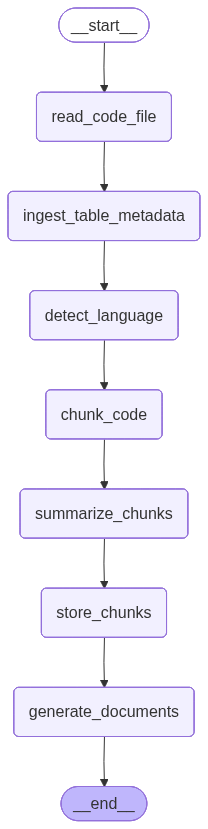

In [42]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        flow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [58]:
def merge_sql_files(file_paths):
    merged = ""
    for path in file_paths:
        with open(path, "r", encoding="utf-8") as f:
            merged += f.read() + "\n"
    return merged

In [77]:
sql_result = flow.invoke({
    "file_path": "./metadata/update_salary_by_department.sql",
    "metadata_file": "./metadata/empMetadata.json"
})

print(sql_result["high_level_doc"])
print(sql_result["detailed_doc"])

📘 High-Level Summary for sql Code

🔹 Chunk 0 Purpose:
This SQL code block creates a stored procedure named `update_salary_by_department` that updates the salaries of all employees in a specific department by a specified percentage increment and returns the total number of employees updated.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**High-level Purpose:**
The high-level purpose of this SQL code block is to create a stored procedure named `update_salary_by_department` that updates the salaries of all employees in a specific department by a specified percentage increment.

**Detailed Logic Explanation:**

1. **Procedure Creation**: The code starts by creating a stored procedure named `update_salary_by_department` that takes two input parameters: `dept_id` (department ID) and `increment_percent` (percentage increment).
2. **Variable Declaration**: A variable `updated_count` is declared to keep track of the number of employees updated.
3. **Salary Update**: The procedur

In [50]:
#Test for java file
java_result = flow.invoke({
    "file_path": "./metadata/SalaryUpdater.java",
    "metadata_file": "./metadata/empMetadata.json"
})

print(java_result["high_level_doc"])
print(java_result["detailed_doc"])

📘 High-Level Summary for java Code

🔹 Chunk 0 Purpose:
This code block is updating the salaries of employees in a specific department by applying a certain increment percentage.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**1. High-level purpose:**
The `updateSalary` method appears to be part of a larger system that manages employee data. Its primary purpose is to update the salaries of employees in a department based on a certain increment percentage.

**2. Detailed logic explanation:**

The `updateSalary` method iterates over a collection of employees (likely stored in a database table named `employees`) using an enhanced for loop. For each employee, it checks if the employee belongs to a specific department (identified by the `deptId` variable). If the employee is in the specified department, the method updates their salary by applying a certain increment percentage (100% in this case).

Here's a step-by-step breakdown of the logic:

1. The method iterates over the

In [51]:
#Test for java file
python_result = flow.invoke({
    "file_path": "./metadata/data_processor.py"
})

print(python_result["high_level_doc"])
print(python_result["detailed_doc"])

📘 High-Level Summary for python Code

🔹 Chunk 0 Purpose:
This code block defines a `DataProcessor` class that processes a collection of records by filtering, computing averages, and tagging high-value records based on specified criteria.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**High-level purpose:**
The provided Python code defines a `DataProcessor` class, which is designed to process a collection of records. The class provides methods for filtering records based on a date range, computing the average value of a specific field, and tagging records with a 'high_value' flag based on a given threshold.

**Detailed logic explanation:**

1. **Initialization**: The `DataProcessor` class is initialized with a list of records, which are stored in the `self.records` attribute.
2. **Filtering by date**: The `filter_by_date` method takes two date parameters, `start_date` and `end_date`, and returns a filtered list of records that fall within the specified date range. It ite

In [69]:
code = merge_sql_files([
    "./metadata/fn_calDeductions.sql",
    "./metadata/fn_getMonthlyAttendence.sql",
    "./metadata/sp_processMonthlyPayroll.sql"
])

In [70]:
payroll_result = flow.invoke({
    "code": code,
    "metadata_file": "./metadata/table_metadata.json"
})

print(payroll_result["high_level_doc"])
print(payroll_result["detailed_doc"])

📘 High-Level Summary for sql Code

🔹 Chunk 0 Purpose:
This code block is designed to automate payroll processing for employees by calculating their gross salary, deductions, and net salary based on their attendance and deductions, and then inserting the processed payroll records into a database table.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**1. High-level purpose**

The provided SQL code block is designed to automate the payroll processing for employees based on their attendance and deductions. It consists of three main components:

- A stored function (`dbo.fn_CalculateDeductions`) to calculate the total deductions for an employee's salary.
- A stored function (`dbo.fn_GetMonthlyAttendance`) to retrieve the number of present days for an employee in a given month and year.
- A stored procedure (`dbo.sp_ProcessPayroll`) to process the payroll for all active employees in a given month and year.

**2. Detailed logic explanation**

### `dbo.fn_CalculateDeductions`

T